<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/Generate_Chicago_Traces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

     |████████████████████████████████| 18.3MB 224kB/s 


In [2]:
# Import necessary packages
import os, os.path
from glob import glob
from shutil import copyfile
import pickle

import pandas as pd
import numpy as np

from secrets import choice

import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading SynthPop data

These files contain people's simulated movements across 24 hr. 

In [4]:
files = glob("drive/My Drive/SatTemp/chicago_synthpop_V2/*.csv.gz")
print(files)

['drive/My Drive/SatTemp/chicago_synthpop_V2/persons_v2.csv.gz', 'drive/My Drive/SatTemp/chicago_synthpop_V2/places_v2_256p_lb_v2.csv.gz', 'drive/My Drive/SatTemp/chicago_synthpop_V2/activities_v2.csv.gz', 'drive/My Drive/SatTemp/chicago_synthpop_V2/places_v2.csv.gz', 'drive/My Drive/SatTemp/chicago_synthpop_V2/places_60615.csv.gz', 'drive/My Drive/SatTemp/chicago_synthpop_V2/persons_60615.csv.gz', 'drive/My Drive/SatTemp/chicago_synthpop_V2/sampled_persons.csv.gz']


In [5]:
!rm -rf synthpop
if not os.path.exists('synthpop'):
  os.mkdir('synthpop')

In [6]:
# copy these files from Google Drive to colab disk
for f in files:
  print(f)
  copyfile(f, 'synthpop/' + os.path.basename(f))

drive/My Drive/SatTemp/chicago_synthpop_V2/persons_v2.csv.gz
drive/My Drive/SatTemp/chicago_synthpop_V2/places_v2_256p_lb_v2.csv.gz
drive/My Drive/SatTemp/chicago_synthpop_V2/activities_v2.csv.gz
drive/My Drive/SatTemp/chicago_synthpop_V2/places_v2.csv.gz
drive/My Drive/SatTemp/chicago_synthpop_V2/places_60615.csv.gz
drive/My Drive/SatTemp/chicago_synthpop_V2/persons_60615.csv.gz
drive/My Drive/SatTemp/chicago_synthpop_V2/sampled_persons.csv.gz


In [7]:
# look at people
persons_df = pd.read_csv('synthpop/persons_v2.csv.gz')
print(len(persons_df))
#persons_df.info()
persons_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2927761


,numeric_id,person_id,hh_id,relate,sex,age,gq_id,school_id,work_id,daycare_id,gym_id,hospital_id,jail,jail_id,rank,weekday_schedule_id_list,weekend_schedule_id_list,otherhh_id,home_restaurant_id,recreation_id,grocery_id,worship_id,work_restaurant_id
0,1,1595930,1181524.0,1.0,2,82,NaN,NaN,NaN,579139.0,1181263.0,70.0,0.000002,1194221,100,5969|5974|5983|5911|5963|5943|5953|5898|5930|5971,12237|12229|12172|12145|12178|12207|12203|1216...,NaN,1197516|1200938|1195562|1196781|1195562,1205986|1206926|1206147|1207623|1207411,1210303|1210303|1210303,1208521.0,1196871|1195562|1200643|1200938|1195361
1,28,1597745,1181535.0,1.0,2,82,NaN,NaN,NaN,598594.0,1181263.0,70.0,0.000002,1194221,135,5914|5905|5908|5903|5921|5911|5930|5985|5965|5924,12207|12158|12180|12219|12172|12168|12216|1215...,NaN,1198007|1202973|1201510|1202764|1201711,1204187|1204188|1207623|1204185|1205247,1210303|1210303|1210271,1208491.0,1199052|1201611|1196871|1201222|1200938
2,335,1830168,1181651.0,2.0,2,80,NaN,NaN,NaN,579512.0,1181504.0,67.0,0.000075,1194221,194,5904|5963|5898|5921|5933|5902|5962|5965|5960|5903,12179|12200|12180|12152|12214|12216|12186|1214...,1106212,1198239|1199738|1201342|1195604|1203026,1206581|1204593|1208218|1204610|1206073,1210268|1210416|1210263,1209887.0,1195893|1203057|1200382|1195061|1199562
3,462,1833607,1181696.0,7.0,2,82,NaN,NaN,NaN,579254.0,1181263.0,70.0,0.000002,1194221,242,5941|5914|5902|5957|5931|5898|5985|5920|5981|5963,12229|12232|12191|12186|12226|12200|12152|1214...,NaN,1199128|1200185|1195781|1196368|1199809,1204184|1206557|1206926|1204185|1205727,1210303|1210271|1210303,1209989.0,1201510|1196631|1194644|1201711|1201711
4,656,1907903,1181820.0,1.0,2,80,NaN,NaN,NaN,598172.0,1181374.0,26.0,0.066281,1194221,84,5898|5929|5930|5913|5982|5924|5915|5903|5916|5900,12185|12193|12189|12178|12144|12152|12206|1216...,NaN,1202359|1198950|1202748|1197743|1194509,1206868|1203252|1206596|1206316|1205545,1210457|1210489|1210268,1208383.0,1201032|1195967|1198994|1199567|1202452


In [10]:
# places
places_df = pd.read_csv('synthpop/places_v2.csv.gz')
places_df['numeric_id'] = places_df['numeric_id'].astype('int64')
#places_df.info()
places_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,numeric_id,place_id,place_type,name,persons,latitude,longitude,zipcode,zip_grp,rank
0,1,10049854,Hospital,NaN,NaN,41.900780,-87.699604,60622.0,2.0,94
1,2,10049882,Hospital,NaN,NaN,41.558686,-87.798062,60477.0,0.0,80
2,3,10049883,Hospital,NaN,NaN,41.895282,-87.619157,60611.0,2.0,81
3,4,10051140,Hospital,NaN,NaN,41.861271,-87.834218,60141.0,0.0,81
4,5,10052705,Hospital,NaN,NaN,41.895516,-87.619425,60611.0,2.0,82


In [11]:
# make it faster to look-up
plidx_df = places_df.set_index('numeric_id')
#plidx_df.info()

In [13]:
# activities
activity_df = pd.read_csv('synthpop/activities_v2.csv.gz')
#activity_df.info()
activity_df.head(20)

,Act_SlNo,start_time,stop_time,Social_Act_Loc,schedule_id
0,1,0,240,Household,3120
1,2,240,480,Household,3120
2,3,480,720,Household,3120
3,4,720,730,Work Restaurant,3120
4,5,730,760,Work Restaurant,3120
5,6,760,765,Other,3120
6,7,765,855,Other,3120
7,8,855,865,Other,3120
8,9,865,867,Other,3120
9,10,867,872,Other Household,3120


In [ ]:
# check the number of unique persons
#print(len(persons_df.person_id), len(persons_df.person_id.unique()))
#persons_df.head()

# Things to do
* join zip code to person -- sample 100 each?
* for each person
  * grab the activity schedule
  * link place coordinates
  * make a row for each hour: 24 rows with coordinates
  * the coordinates for 24 hours will be used to query temperature (or heat stress)


  

In [14]:
person_row = next(persons_df.iterrows())[1]
print(person_row)

numeric_id                                                                  1
person_id                                                             1595930
hh_id                                                             1.18152e+06
relate                                                                      1
sex                                                                         2
age                                                                        82
gq_id                                                                     NaN
school_id                                                                 NaN
work_id                                                                   NaN
daycare_id                                                             579139
gym_id                                                            1.18126e+06
hospital_id                                                                70
jail                                                            

In [ ]:
# %timeit places_df[places_df['numeric_id'] == 1210303]
# %timeit places_df.query('numeric_id == 1210303')
# %timeit plidx_df.loc[1210303]

In [ ]:
# %timeit plidx_df.loc[[1197516,1200938,1195562,1196781,1195562]]
# %timeit [plidx_df.loc[1197516], plidx_df.loc[1200938], plidx_df.loc[1195562], plidx_df.loc[1196781], plidx_df.loc[1195562]]
# %timeit plidx_df.iat[1197517, 4]

In [17]:
def match_activity_with_coord(person_row, activity_df, sch_type='weekday'):

  # retrieve a schedule
  curr_activity = activity_df[activity_df['schedule_id'] == int(choice(person_row[sch_type+'_schedule_id_list'].split('|')))].reset_index(drop=True)

  place_list = curr_activity['Social_Act_Loc'].to_list()
  place_info = []
  prev_place = ''

  item_to_key = {
    'Household': 'hh_id', 
    'Work Restaurant': 'work_restaurant_id',
    'Other': 'hh_id', 
    'Other Household': 'otherhh_id',
    'Place of worship': 'worship_id', 
    'Home Restaurant': 'home_restaurant_id', 
    'Recreation': 'recreation_id',
    'Grocery store': 'grocery_id', 
    'School': 'school_id', 
    'Workplace': 'work_id', 
    'Gym': 'gym_id', 
    'Prison': 'jail_id'
  }

  for item in place_list:
    if item == prev_place:
      curr_info = place_info[-1]
    else:
      if item in item_to_key:
        try:
          if type(person_row[item_to_key[item]]) is str:
            idx = int(choice(person_row[item_to_key[item]].split('|')))
          else:
            idx = int(person_row[item_to_key[item]])
          curr_info = [item, idx, plidx_df.iat[idx, 4], plidx_df.iat[idx, 5]]
        except:
          # if no place was found, force assign household
          idx = int(person_row['hh_id'])
          curr_info = ['FORCE_HH', idx, plidx_df.iat[idx, 4], plidx_df.iat[idx, 5]]
      else:
        curr_info = ['FORCE_HH', idx, plidx_df.iat[idx, 4], plidx_df.iat[idx, 5]]

    #print(curr_info)
    place_info.append(curr_info)
    prev_place = item

  # return the horizontally-concated dataframe
  return(pd.concat([curr_activity, 
                    pd.DataFrame(place_info, columns=['item', 'place_numeric', 'lat', 'lng'])], 
                    axis=1))

%timeit match_activity_with_coord(person_row, activity_df)

place_info = match_activity_with_coord(person_row, activity_df)
place_info

100 loops, best of 3: 3.12 ms per loop


,Act_SlNo,start_time,stop_time,Social_Act_Loc,schedule_id,item,place_numeric,lat,lng
0,1,0,465,Household,5963,Household,1181524,42.018908,-87.807516
1,2,465,540,Household,5963,Household,1181524,42.018908,-87.807516
2,3,540,570,Household,5963,Household,1181524,42.018908,-87.807516
3,4,570,590,Household,5963,Household,1181524,42.018908,-87.807516
4,5,590,595,Household,5963,Household,1181524,42.018908,-87.807516
5,6,595,605,Other,5963,Other,1181524,42.018908,-87.807516
6,7,605,606,Other,5963,Other,1181524,42.018908,-87.807516
7,8,606,610,Grocery store,5963,Grocery store,1210303,42.004586,-87.818446
8,9,610,612,Grocery store,5963,Grocery store,1210303,42.004586,-87.818446
9,10,612,617,Grocery store,5963,Grocery store,1210303,42.004586,-87.818446


In [18]:
# hour, weight, social_act_loc, coordinates (lat/lng)
# using iat (instead of iloc) give ~10x speed improvement

def generate_hourly_activity(act_df):

  schedule = []
  for ii in range(act_df.shape[0]):
    curr_hour = act_df.iat[ii,1] // 60 #.iloc[ii].start_time // 60 
    proc_time = act_df.iat[ii,1] #.start_time

    # take care of the short activity
    if 60*(curr_hour+1) < act_df.iat[ii,2]: #iloc[ii].stop_time:
        schedule.append([curr_hour, 
                        (60*(curr_hour+1) - act_df.iat[ii,1])/60, 
                        act_df.iat[ii,3], act_df.iat[ii,7], act_df.iat[ii,8]]) #.iloc[ii].Social_Act_Loc])
        curr_hour += 1
        proc_time = 60*curr_hour

    # take care of the remaining long activity
    while proc_time < act_df.iat[ii,2]: #iloc[ii].stop_time:
      if (proc_time + 60) < act_df.iat[ii,2]: #iloc[ii].stop_time:
        schedule.append([curr_hour, 1, act_df.iat[ii,3], act_df.iat[ii,7], act_df.iat[ii,8]])
        proc_time += 60
        curr_hour += 1
      else:
        res_act = act_df.iat[ii,2] - proc_time
        schedule.append([curr_hour, res_act/60, act_df.iat[ii,3], act_df.iat[ii,7], act_df.iat[ii,8]])
        proc_time = act_df.iat[ii,2]
    
  # make the schedule compact
  compact_schedule = []
  compact_schedule.append(schedule.copy()[0])
  for item in schedule[1:]:
    # if the hour and activity are the same, just merge the time
    if (item[0] == compact_schedule[-1][0]) & (item[2] == compact_schedule[-1][2]):
      compact_schedule[-1][1] += item[1]
    else:
      compact_schedule.append(item)  

  # done
  return compact_schedule


In [22]:
row = persons_df.sample().iloc[0]
%timeit match_activity_with_coord(row, activity_df)

test = match_activity_with_coord(row, activity_df)
%timeit generate_hourly_activity(test)

test2 = generate_hourly_activity(test)
test2

100 loops, best of 3: 2.99 ms per loop
100 loops, best of 3: 8.27 ms per loop


[[0, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [1, 1, 'Household', 41.7922329975789, -87.66211428901691],
 [2, 1, 'Household', 41.7922329975789, -87.66211428901691],
 [3, 1, 'Household', 41.7922329975789, -87.66211428901691],
 [4, 1, 'Household', 41.7922329975789, -87.66211428901691],
 [5, 1, 'Household', 41.7922329975789, -87.66211428901691],
 [6, 1, 'Household', 41.7922329975789, -87.66211428901691],
 [7, 1, 'Household', 41.7922329975789, -87.66211428901691],
 [8, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [9, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [10, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [11, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [12, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [13, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [14, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [15, 1.0, 'Household', 41.7922329975789, -87.66211428901691],
 [16, 1.0, 'Hous

## join zip code to person -- sample 1000 each?

In [21]:
generate_new_sample = False
num_sample_zip = 100

if generate_new_sample:
  
  # link people and zipcode
  print('Linking people and zipcode')
  pp_loc_df = persons_df.merge(plidx_df['zipcode'], left_on='hh_id', right_index=True)
  pp_loc_df.info()

  # get zipcode that has more than 1000 people in it
  tmp_zip = pp_loc_df.zipcode.value_counts()
  zipcode = list(tmp_zip[tmp_zip > 1000].index)
  print('The number of zip codes to sample: ', len(zipcode))

  # sampling 
  print('Sampling ', num_sample_zip, ' from each zip code')
  sample = pd.DataFrame()
  for zip in zipcode:
    sample = sample.append(pp_loc_df[pp_loc_df['zipcode'] == zip].sample(num_sample_zip))
  
  # save the sample
  sample.to_csv('drive/My Drive/SatTemp/chicago_synthpop_V2/sampled_persons.csv.gz')

else:
  sample = pd.read_csv('synthpop/sampled_persons.csv.gz')

len(sample)

5300

In [ ]:
#sample.info()

In [ ]:
def test():
  for index, person_row in sample.iterrows():
    generate_hourly_activity(
        match_activity_with_coord(person_row, activity_df)
    )

# %timeit test()

# Load the raster data

In [23]:
copyfile("drive/My Drive/SatTemp/SatTemp_Glynn_SELECT/processed.pkl", 'processed_raster.pkl')

'processed_raster.pkl'

In [ ]:
# !ls

In [25]:
with open('processed_raster.pkl', 'rb') as file:
  geo_data = pickle.load(file)

geo_data.keys()

# using the same name
masked_raster = geo_data['lst_raster']
raster_shape = masked_raster[0].shape 
raster_bound = geo_data['boundary']['l00']

In [26]:
masked_raster.shape

(24, 685, 952)

In [27]:
# convert lat/lng to raster xx, yy

uchicago_loc = [41.7886, -87.5987] # lat, lng

def coord_to_raster(coord, bound, shape, verbose=False):
  slope_lat = (bound[3] - bound[1]) / shape[0]
  slope_lng = (bound[2] - bound[0]) / shape[1]
  rst_lat = int(round((bound[3] - coord[0]) / slope_lat)) # lat
  rst_lng = int(round((coord[1] - bound[0]) / slope_lng)) # lng
  if verbose:
    print(coord, ' : (', rst_lat, ',', rst_lng, ')')
  return (rst_lat, rst_lng)

coord_to_raster([raster_bound[1],raster_bound[0]], raster_bound, raster_shape, verbose=True)
coord_to_raster([raster_bound[1],raster_bound[2]], raster_bound, raster_shape, verbose=True)
coord_to_raster([raster_bound[3],raster_bound[0]], raster_bound, raster_shape, verbose=True)
coord_to_raster([raster_bound[3],raster_bound[2]], raster_bound, raster_shape, verbose=True)
coord_to_raster(uchicago_loc, raster_bound, raster_shape, verbose=True)

%timeit coord_to_raster(uchicago_loc, raster_bound, raster_shape)

[41.46612652341049, -88.26368408376308]  : ( 685 , 0 )
[41.46612652341049, -87.31312550993508]  : ( 685 , 952 )
[42.14968408376307, -88.26368408376308]  : ( 0 , 0 )
[42.14968408376307, -87.31312550993508]  : ( 0 , 952 )
[41.7886, -87.5987]  : ( 362 , 666 )
The slowest run took 5.70 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.11 µs per loop


In [28]:
# heat_stress ~ f(temperature, activity, ...)

# convert temperature to heat stress
# no stress below 20 degress, linearly-increasing stress above 20

crit_temp = 20 # degress C

stress_raster = np.where((masked_raster-crit_temp) < 0, 0, (masked_raster-crit_temp))

stress_raster.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


(24, 685, 952)

In [29]:
person_row = sample.iloc[0]
tmp = generate_hourly_activity(
        match_activity_with_coord(person_row, activity_df)
      )
print(tmp)

[[0, 1.0, 'Household', 41.7819731103871, -87.73442549545759], [1, 1, 'Household', 41.7819731103871, -87.73442549545759], [2, 1, 'Household', 41.7819731103871, -87.73442549545759], [3, 1.0, 'Household', 41.7819731103871, -87.73442549545759], [4, 1.0, 'Household', 41.7819731103871, -87.73442549545759], [5, 1, 'Household', 41.7819731103871, -87.73442549545759], [6, 1, 'Household', 41.7819731103871, -87.73442549545759], [7, 1, 'Household', 41.7819731103871, -87.73442549545759], [8, 1, 'Household', 41.7819731103871, -87.73442549545759], [9, 1.0, 'Household', 41.7819731103871, -87.73442549545759], [10, 1.0, 'Household', 41.7819731103871, -87.73442549545759], [11, 1, 'Household', 41.7819731103871, -87.73442549545759], [12, 1, 'Household', 41.7819731103871, -87.73442549545759], [13, 1, 'Household', 41.7819731103871, -87.73442549545759], [14, 1, 'Household', 41.7819731103871, -87.73442549545759], [15, 1.0, 'Household', 41.7819731103871, -87.73442549545759], [16, 1, 'Household', 41.7819731103871

In [34]:
def get_stress(row, stress_raster, raster_bound, raster_shape):
  (xx,yy) = coord_to_raster(row[3:5], raster_bound, raster_shape)
  try:
    return stress_raster[row[0], xx, yy] * row[1]
  except:
    return np.nan

idx = 17
print(tmp[idx])
print(get_stress(tmp[idx], stress_raster, raster_bound, raster_shape))

%timeit get_stress(tmp[0], stress_raster, raster_bound, raster_shape)

[17, 1, 'Household', 41.7819731103871, -87.73442549545759]
14.42384671903551
The slowest run took 7.68 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.78 µs per loop


In [56]:
#%timeit [get_stress(row, stress_raster, raster_bound, raster_shape) for row in tmp]

def get_stress_person(person_row, activity_df, stress_raster, raster_bound, raster_shape):
  #print(person_row)  
  def nan_helper(vct):
    return np.isnan(vct), lambda z: z.nonzero()[0]

  stress_vct = [ 
                get_stress(row, stress_raster, raster_bound, raster_shape) 
                for row in generate_hourly_activity(
                    match_activity_with_coord(person_row, activity_df)
                )]
  
  check, xx = nan_helper(stress_vct)
  if np.isnan(sum(check)):
    stress_vct[check] = np.interp(xx(check), xx(~check), stress_vct(~check))

  #print(stress_vct)
  return sum(stress_vct)

#%timeit get_stress_person(person_row, activity_df, stress_raster, raster_bound, raster_shape)

stress_sum = get_stress_person(person_row, activity_df, stress_raster, raster_bound, raster_shape)
stress_sum

99.62218273326664

probability of provocation ~ f(P1 heat stress, P1 self control)
probability of reactive aggression ~ f(heat stress, self control, etc)

--> Jonathan's HIV work



In [57]:
def calculate_stress_score(sample, verbose=False):
  
  stress_score = []

  for index, person_row in sample.iterrows():
    if verbose & (index % 300 == 299):
      print('Processing ', index)
      
    try:
      stress_score.append(
          get_stress_person(person_row, activity_df, stress_raster, raster_bound, raster_shape)
      )
    except:
      stress_score.append(np.nan)
  
  if verbose:
    print('Done.')
  return stress_score

#%timeit calculate_stress_score(sample)

stress_score = calculate_stress_score(sample, verbose=True)
print('Number of NaN values: ', sum(np.isnan(stress_score)))

Processing  299
Processing  599
Processing  899
Processing  1199
Processing  1499
Processing  1799
Processing  2099
Processing  2399
Processing  2699
Processing  2999
Processing  3299
Processing  3599
Processing  3899
Processing  4199
Processing  4499
Processing  4799
Processing  5099
Done.
Number of NaN values:  316


In [58]:
stress_df = sample[['person_id', 'sex', 'age', 'zipcode']].merge(
    pd.DataFrame(stress_score, columns=['stress_score']), 
    left_index=True, right_index=True)

In [59]:
agg_by_zip = stress_df.groupby('zipcode').agg({
    'sex': lambda x: (x==1).mean(), 
    'age': np.nanmean, 
    'stress_score': [np.nanmean, lambda x: x.isnull().mean()]
}).reset_index('zipcode')

agg_by_zip.head()

zipcode      sex     age stress_score           
           <lambda> nanmean      nanmean <lambda_0>
0  60601.0     0.42   44.23     7.054384       0.01
1  60605.0     0.39   38.74    17.950474       0.00
2  60606.0     0.60   35.18    47.055291       0.01
3  60607.0     0.47   36.12    88.596848       0.00
4  60608.0     0.46   25.81    99.134089       0.02

In [61]:
agg_by_zip.columns = ['zipcode', 'gender_ratio', 'mean_age', 'stress_score', 'nan_ratio']

agg_by_zip

,zipcode,gender_ratio,mean_age,stress_score,nan_ratio
0,60601.0,0.42,44.23,7.054384,0.01
1,60605.0,0.39,38.74,17.950474,0.00
2,60606.0,0.60,35.18,47.055291,0.01
3,60607.0,0.47,36.12,88.596848,0.00
4,60608.0,0.46,25.81,99.134089,0.02
5,60609.0,0.41,25.66,97.471968,0.00
6,60610.0,0.54,40.05,33.303120,0.22
7,60611.0,0.48,43.88,10.723489,0.00
8,60612.0,0.46,32.21,118.908793,0.01
9,60613.0,0.45,34.89,66.579587,0.64


In [62]:
agg_by_zip['zip'] = agg_by_zip['zipcode'].astype('int').astype('str')

# Visulaize!

In [63]:
!apt install python-rtree=0.8.3+ds-1
!pip install geopandas==0.7.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources
Suggested packages:
  apache2 | lighttpd | httpd python-setuptools
The following NEW packages will be installed:
  javascript-common libjs-jquery libjs-underscore libspatialindex-c4v5
  libspatialindex-dev libspatialindex4v5 python-pkg-resources python-rtree
0 upgraded, 8 newly installed, 0 to remove and 21 not upgraded.
Need to get 959 kB of archives.
After this operation, 5,144 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 javascript-common all 11 [6,066 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-jquery all 3.2.1-1 [152 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjs-underscore all 1.8.3~dfsg-1 [59.9 kB]
Get:4 htt

In [64]:
import geopandas as gpd
from fiona.crs import from_epsg


In [65]:
chi_zipcode = gpd.read_file('https://data.cityofchicago.org/api/geospatial/gdcf-axmw?method=export&format=GeoJSON', # zipcode
                            crs = from_epsg(2163)).to_crs(epsg = 3528)

In [66]:
chi_zipcode.head()

,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((354394.891 583175.936, 354396...."
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((350308.709 583688.854, 350300...."
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((345493.140 582157.103, 345467...."
3,36,70853834.3797,42527.9896789,60622,"MULTIPOLYGON (((355295.245 579972.119, 355295...."
4,37,99039621.2518,47970.1401531,60651,"MULTIPOLYGON (((352012.599 580691.759, 351998...."


In [67]:
# merge heat stress with zipcode
stress_gdf = pd.merge(chi_zipcode, agg_by_zip, how='left', left_on='zip', right_on='zip')

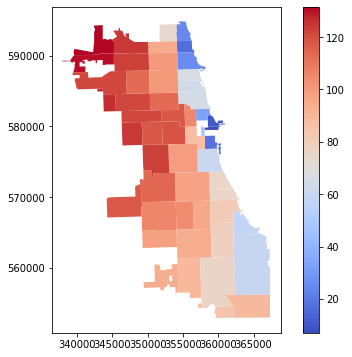

In [69]:
ax = stress_gdf.plot(column='stress_score',
                     cmap = "coolwarm",
                     legend = True,
                     figsize=(8,6))

### Compare with Ashish's heat vulnerability index figure
https://iopscience.iop.org/article/10.1088/1748-9326/aad93c

Note that the above figure should look like the Roof Temp panel because the current heat stress score is entirely determined by the Land Surface Temperature.

![picture](https://cdn.iopscience.com/images/1748-9326/13/9/094011/Full/erlaad93cf3_lr.jpg)